# Informações

## **Variável Dependente**

| Item | Detalhes |
|------|----------|
| **Variável Utilizada** | `RL_Rp_ew_cc` |
| **Fórmula de Cálculo** | \[ \text{RL\_Rp\_ew\_cc} = \text{Rp\_ew\_cc} - \text{RF} \] |
| **Interpretação** | Excesso de retorno do portfólio em relação à taxa livre de risco |

##  **Variáveis Independentes**

### **Fatores Utilizados no Modelo:**
- **CMA** - Conservative Minus Aggressive (Investimento)
- **HML** - High Minus Low (Valor)  
- **LT_Rev** - Long-Term Reversal (Reversão de Longo Prazo)
- **MktRF** - Market Excess Return (Retorno do Mercado em Excesso)
- **Mom** - Momentum (Momentum)
- **RMW** - Robust Minus Weak (Rentabilidade)
- **SMB** - Small Minus Big (Tamanho)
- **ST_Rev** - Short-Term Reversal (Reversão de Curto Prazo)

## **Período de Análise**

### **Crise Dot-com**
| Item | Detalhes |
|------|----------|
| **Período** | 01 de Março de 2000 - 31 de Outubro de 2002 |
| **Duração** | ~2 anos e 8 meses |
| **Contexto** | Colapso das empresas de tecnologia |

### **Crise do Subprime**
| Item | Detalhes |
|------|----------|
| **Período** | 01 de Setembro de 2007 - 31 de Março de 2009 |
| **Duração** | ~1 ano e 7 meses |
| **Contexto** | Crise financeira global |

---

##  **Legenda das Variáveis**

| Símbolo | Significado |
|---------|-------------|
| **RL** | Excess Return (Retorno em Excesso) |
| **Rp** | Portfolio Return (Retorno do Portfólio) |
| **ew** | Equal Weighted (Ponderado Igualmente) |
| **cc** | Currency Adjusted (Ajustado pela Moeda) |
| **RF** | Risk Free (Taxa Livre de Risco) |
| **MktRF** | Market Risk Factor (Fator de Risco de Mercado) |

---

##  **Metodologia**

O estudo utiliza **dois períodos de crise financeira** distintos para analisar o comportamento dos fatores de Fama-French durante momentos de alta volatilidade e estresse de mercado.

### **Importação dos pacotes**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.regressionplots import (
    plot_partregress_grid, influence_plot, plot_leverage_resid2
)

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance

!pip install pingouin

from scipy import stats
import pingouin as pg   # para correlações com p-value
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy.stats import boxcox, boxcox_normmax

from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import yeojohnson


### **Leitura dos dados**

In [3]:
FFF = pd.read_csv("FFF_ret(in).csv")

FFF["Rt_Rp_ew_cc"] = FFF["Rp_ew_cc"] - FFF["Rf"]

# Renomear colunas se precisar
FFF = FFF.rename(columns={"Rm-Rf": "MktRF"})

y_clean = FFF.Rt_Rp_ew_cc.replace([np.inf, -np.inf], np.nan).dropna()

X = FFF[["MktRF", "SMB", "HML", "RMW", "CMA", "Mom", "ST_Rev", "LT_Rev"]]

dados_validos = FFF[["Rt_Rp_ew_cc", "MktRF", "SMB", "HML", "RMW", "CMA", "Mom", "ST_Rev", "LT_Rev"]].replace([np.inf, -np.inf], np.nan).dropna()

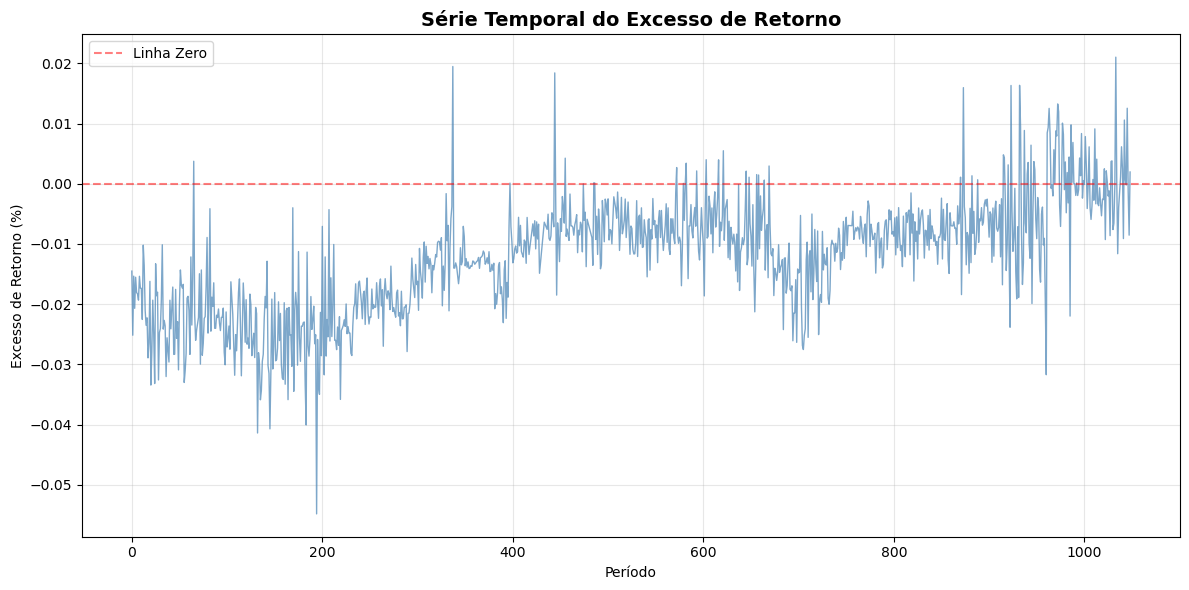

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(dados_validos.index, dados_validos['Rt_Rp_ew_cc'], 
         linewidth=1, alpha=0.7, color='steelblue')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Linha Zero')
plt.title('Série Temporal do Excesso de Retorno', fontsize=14, fontweight='bold')
plt.xlabel('Período')
plt.ylabel('Excesso de Retorno (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## **1 - Correlações e Heatmap**

                MktRF       SMB       HML       RMW       CMA       Mom  \
MktRF        1.000000 -0.065012 -0.106468 -0.416465 -0.468342 -0.502160   
SMB         -0.065012  1.000000 -0.003051 -0.309063  0.014994  0.083040   
HML         -0.106468 -0.003051  1.000000  0.311061  0.543816 -0.263356   
RMW         -0.416465 -0.309063  0.311061  1.000000  0.512287  0.201670   
CMA         -0.468342  0.014994  0.543816  0.512287  1.000000  0.247573   
Mom         -0.502160  0.083040 -0.263356  0.201670  0.247573  1.000000   
ST_Rev       0.552658  0.018629 -0.167989 -0.423683 -0.453779 -0.304860   
LT_Rev      -0.351784  0.335698  0.417127  0.047369  0.540471  0.247692   
Rt_Rp_ew_cc  0.141503 -0.008697 -0.002769 -0.088963 -0.075795 -0.127404   

               ST_Rev    LT_Rev  Rt_Rp_ew_cc  
MktRF        0.552658 -0.351784     0.141503  
SMB          0.018629  0.335698    -0.008697  
HML         -0.167989  0.417127    -0.002769  
RMW         -0.423683  0.047369    -0.088963  
CMA         -0

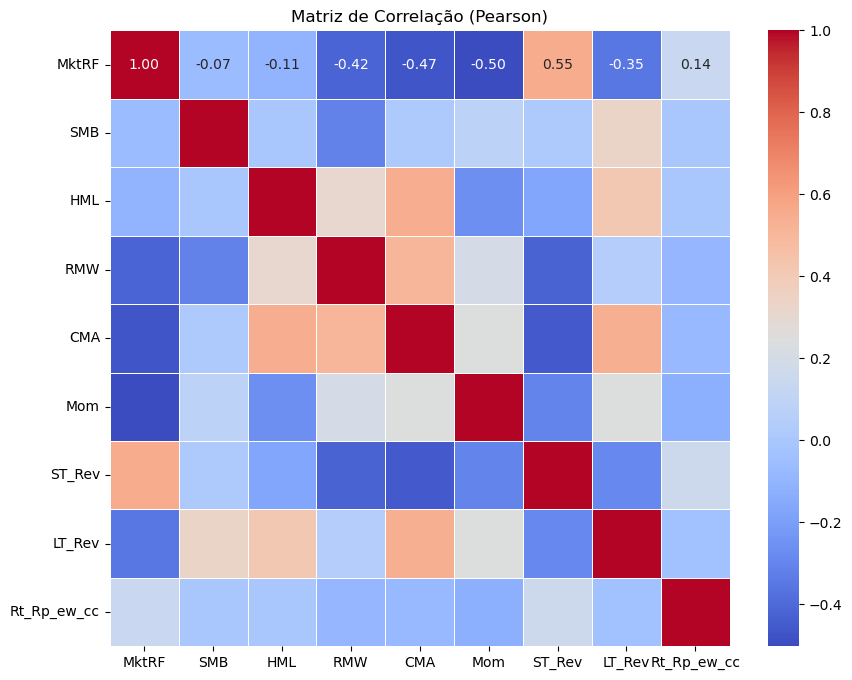

In [5]:
corr_vars = X.copy()  # pega as mesmas colunas definidas em X
corr_vars["Rt_Rp_ew_cc"] = y_clean  # adiciona a variável dependente ao conjunto

# Calcular correlação de Pearson
corr = corr_vars.corr(method="pearson")

# Exibir matriz de correlação
print(corr)

# Criar o Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação (Pearson)")
plt.show()

## **1.2 - Scatterplots para visualização das relações**

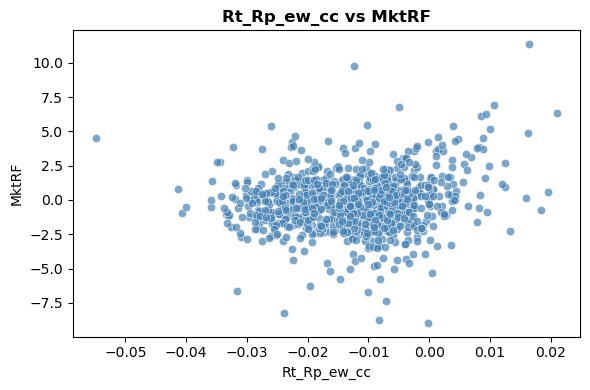

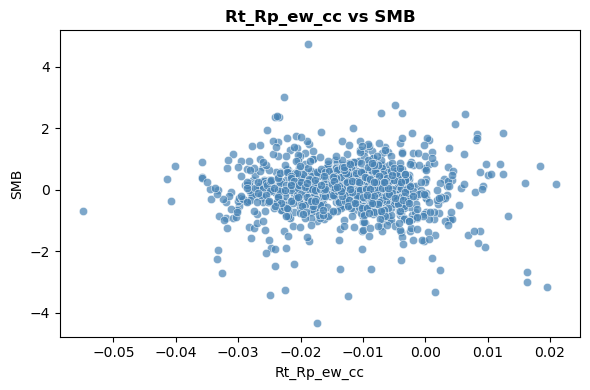

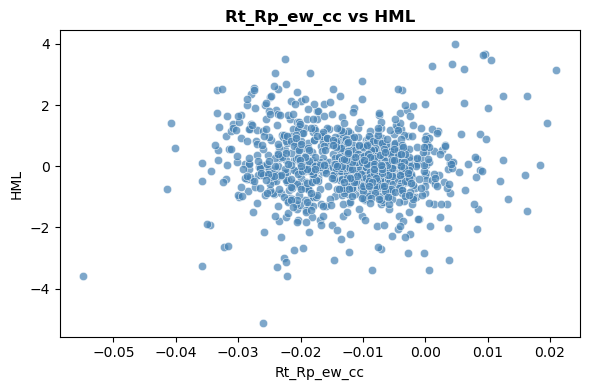

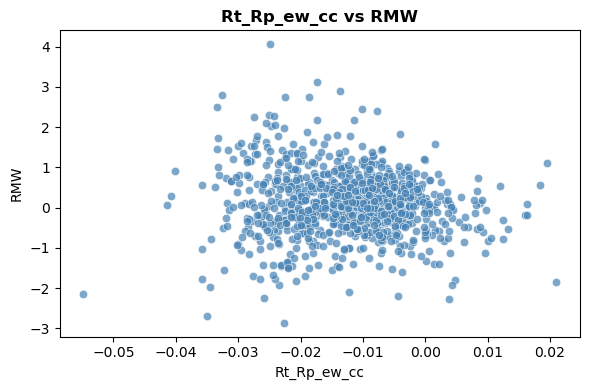

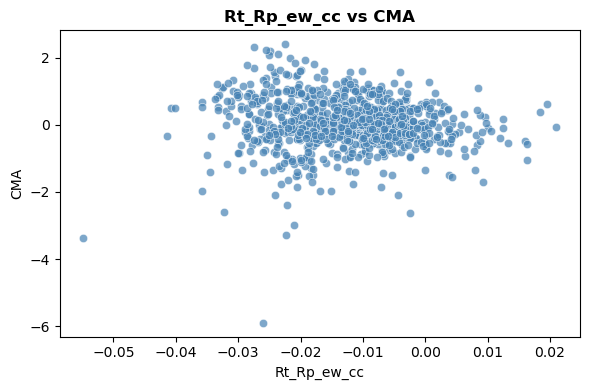

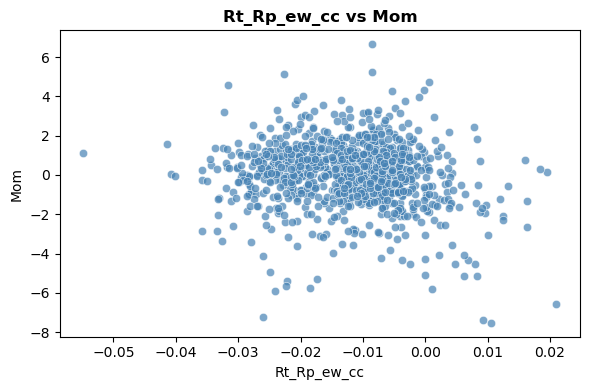

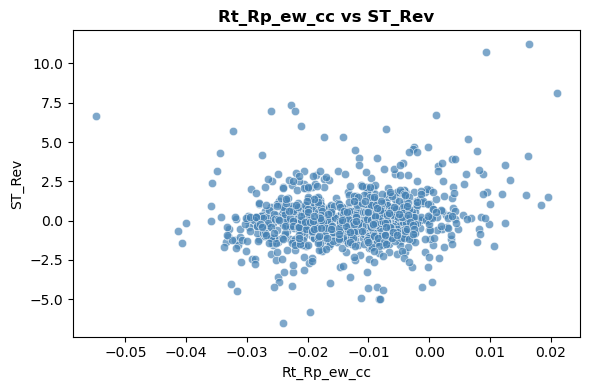

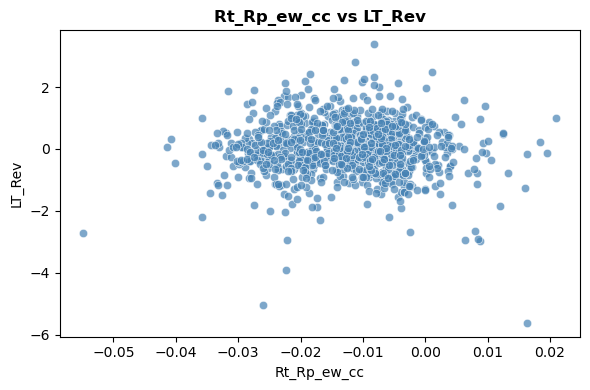

In [6]:
FFF_clean = X.copy()                      # copia as variáveis explicativas
FFF_clean["Rt_Rp_ew_cc"] = y_clean        # adiciona a variável dependente

# Remover possíveis valores infinitos ou nulos
FFF_clean = FFF_clean.replace([np.inf, -np.inf], np.nan).dropna()

# Lista de colunas (agora reaproveitada)
cols = FFF_clean.columns.tolist()

# ============================================
# Geração dos gráficos de dispersão (scatterplots)
# ============================================
for i in range(0, len(cols) - 1):  # percorre todas as variáveis explicativas
    plt.figure(figsize=(6, 4))     # define o tamanho do gráfico (largura x altura)

    # Cria o gráfico de dispersão entre Rt_Rp_ew_cc e cada variável explicativa
    sns.scatterplot(
        data=FFF_clean,
        x="Rt_Rp_ew_cc",          # variável dependente no eixo X
        y=cols[i],                # variável explicativa no eixo Y
        color="steelblue",        # cor dos pontos
        alpha=0.7                 # transparência dos pontos
    )

    # Adiciona título e rótulos
    plt.title(f"Rt_Rp_ew_cc vs {cols[i]}", fontsize=12, weight="bold")
    plt.xlabel("Rt_Rp_ew_cc")
    plt.ylabel(cols[i])

    # Mostra o gráfico
    plt.tight_layout()  # ajusta espaçamento para não cortar textos
    plt.show()

## **2 - Regressão Linear Múltipla**

In [7]:
formula = "Rt_Rp_ew_cc ~ " + " + ".join(X.columns)

fit = smf.ols(formula, data=FFF_clean).fit()
print(fit.summary())

model = fit  # compatibilizar com o código do Box-Cox


                            OLS Regression Results                            
Dep. Variable:            Rt_Rp_ew_cc   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     4.607
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           1.54e-05
Time:                        10:05:23   Log-Likelihood:                 3372.9
No. Observations:                1035   AIC:                            -6728.
Df Residuals:                    1026   BIC:                            -6683.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0122      0.000    -40.819      0.0

## **3 - Teste de Box-Cox**

=== APLICAÇÃO DO TESTE BOX-COX ===
Lambda ideal encontrado: 1.1896
Shapiro-Wilk ORIGINAL: p-value = 3.51e-08 (do seu resultado anterior)
Shapiro-Wilk BOX-COX: ShapiroResult(statistic=0.9906826615333557, pvalue=3.921285497199278e-06)


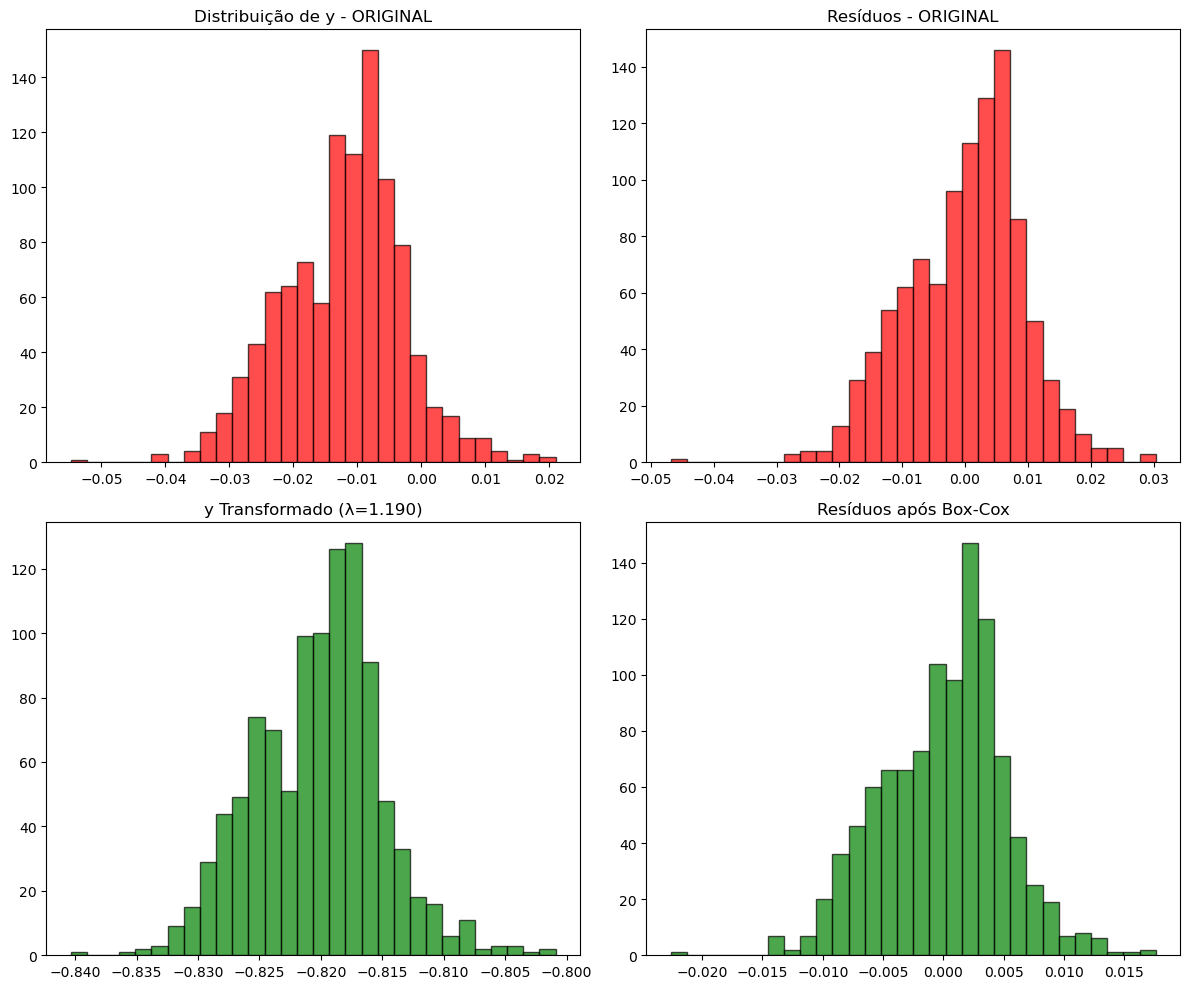


=== INTERPRETAÇÃO DO LAMBDA (1.1896) ===
→ Transformação de potência (assimetria específica)

=== COMPARAÇÃO DE MODELOS ===
R² Original: 0.035 (do seu resultado anterior)
R² Box-Cox: 0.0378

=== TESTE DE NORMALIDADE ===
Shapiro-Wilk Box-Cox: estatística=0.9907, p-value=0.000004
⚠️  RESULTADO: Resíduos ainda NÃO-NORMAIS

=== RECOMENDAÇÃO ===
Use: y_transformado = (y^1.190 - 1) / 1.190


In [8]:
print("=== APLICAÇÃO DO TESTE BOX-COX ===")

# Separar variáveis dependente e independentes alinhadas
y_clean = dados_validos["Rt_Rp_ew_cc"]
X = dados_validos[["MktRF", "SMB", "HML", "RMW", "CMA", "Mom", "ST_Rev", "LT_Rev"]]

# Preparar dados para Box-Cox (não pode ter valores <= 0)
y_prepared = y_clean - y_clean.min() + 0.001

# Encontrar lambda ótimo
y_transformed, lambda_val = stats.boxcox(y_prepared)

# Adicionar constante e ajustar modelo
X_const = sm.add_constant(X)
modelo_boxcox = sm.OLS(y_transformed, X_const).fit()

print(f"Lambda ideal encontrado: {lambda_val:.4f}")

# Caso o modelo original não esteja carregado
print("Shapiro-Wilk ORIGINAL: p-value = 3.51e-08 (do seu resultado anterior)")
print(f"Shapiro-Wilk BOX-COX: {stats.shapiro(modelo_boxcox.resid)}")

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].hist(y_clean, bins=30, alpha=0.7, color='red', edgecolor='black')
axes[0,0].set_title('Distribuição de y - ORIGINAL')

axes[0,1].hist(model.resid, bins=30, alpha=0.7, color='red', edgecolor='black')
axes[0,1].set_title('Resíduos - ORIGINAL')

axes[1,0].hist(y_transformed, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1,0].set_title(f'y Transformado (λ={lambda_val:.3f})')

axes[1,1].hist(modelo_boxcox.resid, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1,1].set_title('Resíduos após Box-Cox')

plt.tight_layout()
plt.show()

# Interpretação do lambda
print(f"\n=== INTERPRETAÇÃO DO LAMBDA ({lambda_val:.4f}) ===")

if abs(lambda_val - 1) < 0.1:
    print("→ λ ≈ 1: Pouca transformação necessária")
elif abs(lambda_val) < 0.1:
    print("→ λ ≈ 0: Transformação logarítmica")
elif lambda_val < 0:
    print("→ Transformação inversa (assimetria negativa)")
elif lambda_val < 0.5:
    print("→ Transformação de raiz (assimetria positiva moderada)")
else:
    print("→ Transformação de potência (assimetria específica)")

# Comparação de modelos
print(f"\n=== COMPARAÇÃO DE MODELOS ===")
print("R² Original: 0.035 (do seu resultado anterior)")
print(f"R² Box-Cox: {modelo_boxcox.rsquared:.4f}")

# Teste de normalidade formal
print(f"\n=== TESTE DE NORMALIDADE ===")
shapiro_boxcox = stats.shapiro(modelo_boxcox.resid)
print(f"Shapiro-Wilk Box-Cox: estatística={shapiro_boxcox[0]:.4f}, p-value={shapiro_boxcox[1]:.6f}")

if shapiro_boxcox[1] > 0.05:
    print("✅ RESULTADO: Resíduos NORMAIS após Box-Cox")
else:
    print("⚠️  RESULTADO: Resíduos ainda NÃO-NORMAIS")

# Recomendação final
print(f"\n=== RECOMENDAÇÃO ===")
if abs(lambda_val - 1) < 0.1:
    print("Box-Cox não é necessário - dados já adequados")
else:
    print(f"Use: y_transformado = (y^{lambda_val:.3f} - 1) / {lambda_val:.3f}")
    if abs(lambda_val) < 0.05:
        print("Ou aproximadamente: y_transformado = log(y)")


## **4 - Seleção do modelo**

In [14]:
lin_reg = LinearRegression()

# BACKWARD
sfs_bwd = SequentialFeatureSelector(lin_reg, n_features_to_select="auto", direction="backward")
sfs_bwd.fit(X, y_clean)
selected_bwd = X.columns[sfs_bwd.get_support()]
X_bwd = X[selected_bwd]

# FORWARD
sfs_fwd = SequentialFeatureSelector(lin_reg, n_features_to_select="auto", direction="forward")
sfs_fwd.fit(X, y_clean)
selected_fwd = X.columns[sfs_fwd.get_support()]
X_fwd = X[selected_fwd]

# STEPWISE usando statsmodels
def stepwise_selection(X, y_clean, threshold_in=0.05, threshold_out=0.05):
    included = []
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y_clean, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            
        # Backward step
        model = sm.OLS(y_clean, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            
        if not changed:
            break
    return included

selected_step = stepwise_selection(X, y_clean)
X_step = X[selected_step]

# COMPARAR MODELOS

# Backward
lin_reg.fit(X_bwd, y_clean)
y_pred_bwd = lin_reg.predict(X_bwd)
print("Backward R2:", r2_score(y_clean, y_pred_bwd))
print("Backward RMSE:", np.sqrt(mean_squared_error(y_clean, y_pred_bwd)))

# Forward
lin_reg.fit(X_fwd, y_clean)
y_pred_fwd = lin_reg.predict(X_fwd)
print("Forward R2:", r2_score(y_clean, y_pred_fwd))
print("Forward RMSE:", np.sqrt(mean_squared_error(y_clean, y_pred_fwd)))

# Stepwise
lin_reg.fit(X_step, y_clean)
y_pred_step = lin_reg.predict(X_step)
print("Stepwise R2:", r2_score(y_clean, y_pred_step))
print("Stepwise RMSE:", np.sqrt(mean_squared_error(y_clean, y_pred_step)))

# Modelo backward
model_bwd = sm.OLS(y_clean, sm.add_constant(X_bwd)).fit()
print(f"Backward AIC: {model_bwd.aic}, BIC: {model_bwd.bic}")

# Modelo Forward
model_fwd = sm.OLS(y_clean, sm.add_constant(X_fwd)).fit()
print(f"Forward AIC: {model_fwd.aic}, BIC: {model_fwd.bic}")

# Modelo Stepwise
model_step = sm.OLS(y_clean, sm.add_constant(X_step)).fit()
print(f"Stepwise AIC: {model_step.aic}, BIC: {model_step.bic}")

print("\nVariáveis selecionadas:")
print(f"Backward: {list(selected_bwd)}")
print(f"Forward: {list(selected_fwd)}")
print(f"Stepwise: {selected_step}")

Backward R2: 0.02490902194665312
Backward RMSE: 0.009346524575944674
Forward R2: 0.02490902194665312
Forward RMSE: 0.009346524575944674
Stepwise R2: 0.03173492275727674
Stepwise RMSE: 0.009313753021681293
Backward AIC: -6731.391201594046, BIC: -6721.506888182647
Forward AIC: -6731.391201594046, BIC: -6721.506888182647
Stepwise AIC: -6736.661960211002, BIC: -6721.835490093904

Variáveis selecionadas:
Backward: ['ST_Rev']
Forward: ['ST_Rev']
Stepwise: ['ST_Rev', 'Mom']


## **5 - Testes de Multicolineariedade**

In [10]:
# Adiciona constante
X_const = sm.add_constant(X_step)

# ---- VIF ----
vif = pd.DataFrame()
vif["feature"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print("### VIF ###")
print(vif)

# ---- Condition Number ----
cond_number = np.linalg.cond(X_const)
print("\n### Número de Condição ###")
print(cond_number)

# ---- Interpretação ----
if all(vif["VIF"] < 5) and cond_number < 30:
    print("\n✅ Não há sinais de multicolinearidade.")
elif any(vif["VIF"] > 10) or cond_number > 100:
    print("\n⚠️ Forte multicolinearidade detectada.")
else:
    print("\n⚠️ Há alguma evidência de multicolinearidade moderada.")


### VIF ###
  feature       VIF
0   const  1.012641
1  ST_Rev  1.105904
2     Mom  1.105904

### Número de Condição ###
1.8596291995409422

✅ Não há sinais de multicolinearidade.


## **6 - Cook's Distance, DFFITS, DFBETAS, Hat Value**

Observações após alinhamento: 1035
Primeiras 5 observações:
   Cooks_Distance    DFFITS  Hat_Values  Resid_Student  Resid_Standard  \
0        0.000007 -0.004661    0.001487      -0.120787       -0.120845   
1        0.001009 -0.055051    0.001670      -1.346042       -1.345513   
2        0.000016 -0.006936    0.002400      -0.141410       -0.141477   
3        0.000464 -0.037287    0.003240      -0.654042       -0.654223   
4        0.000027 -0.009041    0.001369      -0.244206       -0.244318   

   COVRATIO  DFBETA_const  DFBETA_ST_Rev  DFBETA_Mom  
0  1.004363     -0.003812       0.001554   -0.001686  
1  0.999312     -0.038683      -0.016538   -0.035242  
2  1.005267     -0.004369       0.001762   -0.004270  
3  1.004921     -0.022704       0.028231   -0.003975  
4  1.004113     -0.007724       0.003041   -0.002716  

Estatísticas descritivas:
       Cooks_Distance       DFFITS   Hat_Values  Resid_Student  \
count    1.035000e+03  1035.000000  1035.000000    1035.000000   
mean  

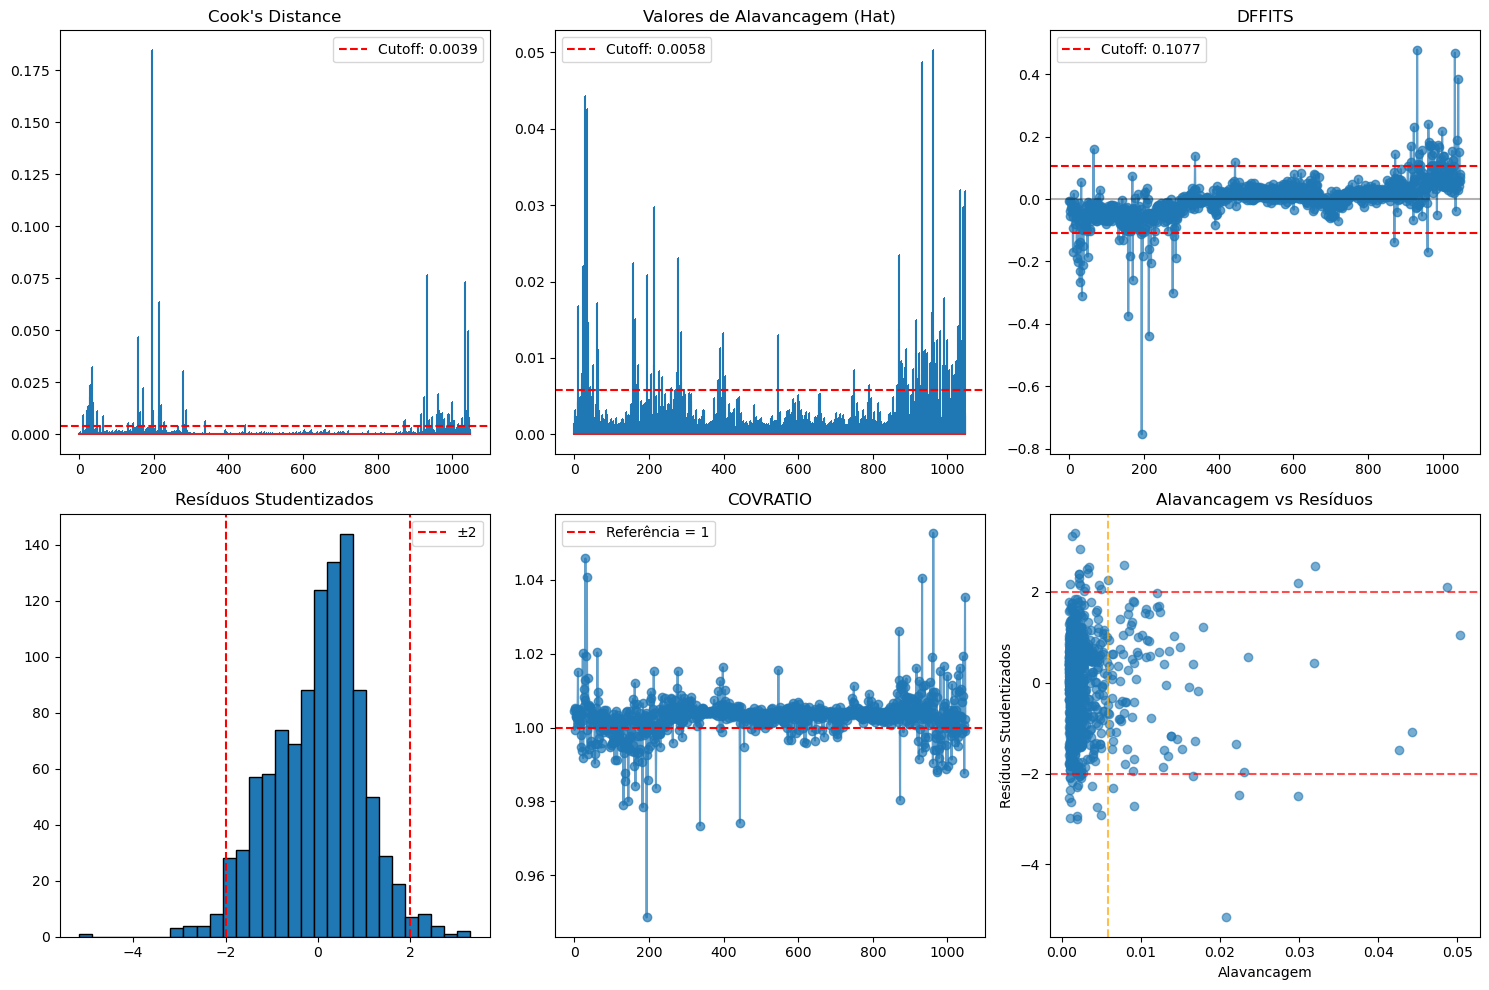


=== OBSERVAÇÕES MAIS INFLUENTES ===
Encontradas 118 observações influentes:
      Cooks_Distance  Hat_Values    DFFITS
194         0.184878    0.020819 -0.753967
932         0.076368    0.048682  0.479459
1033        0.073085    0.032008  0.469531
213         0.063471    0.029810 -0.437467
1042        0.049568    0.029818  0.386341
158         0.046542    0.022381 -0.374593
34          0.032363    0.042590 -0.311770
277         0.030241    0.023088 -0.301620
28          0.023683    0.016625 -0.266963
170         0.022451    0.009128 -0.260324


In [15]:
# SOLUÇÃO CORRIGIDA - Garantir alinhamento de índices

# Primeiro garantir que X e y estejam alinhados
X_aligned = dados_validos[X_step.columns]
y_aligned = dados_validos[y_clean.name]

print(f"Observações após alinhamento: {len(X_aligned)}")

# 2. Ajustar o modelo com dados alinhados
X_const = sm.add_constant(X_aligned)
model = sm.OLS(y_aligned, X_const).fit()

# 3. Obter influência
influence = model.get_influence()

# ---- 1. Resíduos studentizados e padronizados ----
resid_student = influence.resid_studentized_external  # resíduos studentizados
resid_standard = influence.resid_studentized_internal # resíduos padronizados

# ---- 2. Alavancagem (Hat Values) ----
hat_values = influence.hat_matrix_diag

# ---- 3. Medidas de influência ----
cooks_d, _ = influence.cooks_distance
dffits, _ = influence.dffits
dfbetas = influence.dfbetas
cov_ratio = influence.cov_ratio

# ---- Organizar em DataFrame ----
diagnostics = pd.DataFrame({
    "Cooks_Distance": cooks_d,
    "DFFITS": dffits,
    "Hat_Values": hat_values,
    "Resid_Student": resid_student,
    "Resid_Standard": resid_standard,
    "COVRATIO": cov_ratio
}, index=X_aligned.index)  # Manter os mesmos índices

# Adicionar DFBETAS (um por variável)
for i, col in enumerate(model.params.index):
    diagnostics[f"DFBETA_{col}"] = dfbetas[:, i]

print("Primeiras 5 observações:")
print(diagnostics.head())

print(f"\nEstatísticas descritivas:")
print(diagnostics.describe())

# ---- Identificar observações influentes ----
n = len(X_aligned)
k = len(model.params) - 1

# Limites
cooks_cutoff = 4 / (n - k - 1)
hat_cutoff = 2 * (k + 1) / n
dffits_cutoff = 2 * np.sqrt((k + 1) / n)

print(f"\n--- LIMITES PARA OBSERVAÇÕES INFLUENTES ---")
print(f"Cook's D > {cooks_cutoff:.4f}")
print(f"Hat Values > {hat_cutoff:.4f}")
print(f"|DFFITS| > {dffits_cutoff:.4f}")

# Observações problemáticas
high_cooks = diagnostics[diagnostics['Cooks_Distance'] > cooks_cutoff]
high_hat = diagnostics[diagnostics['Hat_Values'] > hat_cutoff]
high_dffits = diagnostics[np.abs(diagnostics['DFFITS']) > dffits_cutoff]

print(f"\nObservações com alta influência:")
print(f"Cook's D: {len(high_cooks)} observações")
print(f"Alavancagem: {len(high_hat)} observações") 
print(f"DFFITS: {len(high_dffits)} observações")

# ---- Visualização ----

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Cook's Distance
axes[0,0].stem(diagnostics.index, diagnostics['Cooks_Distance'], markerfmt=",")
axes[0,0].axhline(cooks_cutoff, color='red', linestyle='--', label=f'Cutoff: {cooks_cutoff:.4f}')
axes[0,0].set_title("Cook's Distance")
axes[0,0].legend()

# 2. Hat Values
axes[0,1].stem(diagnostics.index, diagnostics['Hat_Values'], markerfmt=",")
axes[0,1].axhline(hat_cutoff, color='red', linestyle='--', label=f'Cutoff: {hat_cutoff:.4f}')
axes[0,1].set_title("Valores de Alavancagem (Hat)")
axes[0,1].legend()

# 3. DFFITS
axes[0,2].plot(diagnostics.index, diagnostics['DFFITS'], 'o-', alpha=0.7)
axes[0,2].axhline(dffits_cutoff, color='red', linestyle='--', label=f'Cutoff: {dffits_cutoff:.4f}')
axes[0,2].axhline(-dffits_cutoff, color='red', linestyle='--')
axes[0,2].axhline(0, color='black', alpha=0.3)
axes[0,2].set_title("DFFITS")
axes[0,2].legend()

# 4. Resíduos Studentizados
axes[1,0].hist(diagnostics['Resid_Student'], bins=30, edgecolor='black')
axes[1,0].axvline(2, color='red', linestyle='--', label='±2')
axes[1,0].axvline(-2, color='red', linestyle='--')
axes[1,0].set_title("Resíduos Studentizados")
axes[1,0].legend()

# 5. COVRATIO
axes[1,1].plot(diagnostics.index, diagnostics['COVRATIO'], 'o-', alpha=0.7)
axes[1,1].axhline(1, color='red', linestyle='--', label='Referência = 1')
axes[1,1].set_title("COVRATIO")
axes[1,1].legend()

# 6. Scatter: Alavancagem vs Resíduos
axes[1,2].scatter(diagnostics['Hat_Values'], diagnostics['Resid_Student'], alpha=0.6)
axes[1,2].axhline(2, color='red', linestyle='--', alpha=0.7)
axes[1,2].axhline(-2, color='red', linestyle='--', alpha=0.7)
axes[1,2].axvline(hat_cutoff, color='orange', linestyle='--', alpha=0.7)
axes[1,2].set_xlabel('Alavancagem')
axes[1,2].set_ylabel('Resíduos Studentizados')
axes[1,2].set_title("Alavancagem vs Resíduos")

plt.tight_layout()
plt.show()

# ---- Resumo das observações mais influentes ----
print(f"\n=== OBSERVAÇÕES MAIS INFLUENTES ===")

# Combinar critérios
influential_obs = diagnostics[
    (diagnostics['Cooks_Distance'] > cooks_cutoff) |
    (diagnostics['Hat_Values'] > hat_cutoff) |
    (np.abs(diagnostics['DFFITS']) > dffits_cutoff)
]

if len(influential_obs) > 0:
    print(f"Encontradas {len(influential_obs)} observações influentes:")
    print(influential_obs[['Cooks_Distance', 'Hat_Values', 'DFFITS']].sort_values('Cooks_Distance', ascending=False).head(10))
else:
    print("Nenhuma observação extremamente influente detectada")

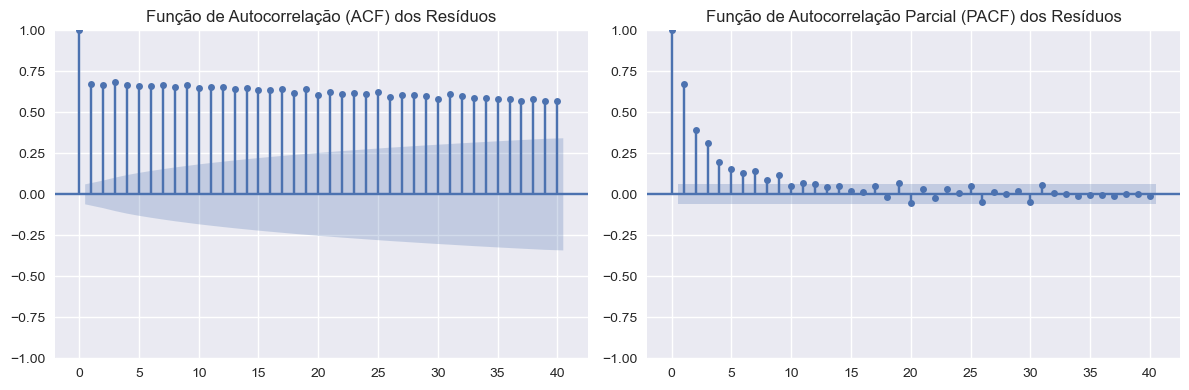

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

residuos = model.resid  # resíduos do modelo ajustado

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ACF
plot_acf(residuos, lags=40, ax=axes[0])
axes[0].set_title('Função de Autocorrelação (ACF) dos Resíduos')

# PACF
plot_pacf(residuos, lags=40, ax=axes[1])
axes[1].set_title('Função de Autocorrelação Parcial (PACF) dos Resíduos')

plt.tight_layout()
plt.show()

In [40]:
# Exemplo de cálculo dos limites (para referência)
n = len(y_clean)  # número de observações
k = X.shape[1]  # número de variáveis independentes

print("📏 LIMITES CALCULADOS:")
print(f"Cook's Distance: {4/(n-k-1):.4f}")
print(f"Hat Values: {2*(k+1)/n:.4f}") 
print(f"DFFITS: ±{2*np.sqrt((k+1)/n):.4f}")
print(f"COVRATIO: [1 - {3*(k+1)/n:.4f}, 1 + {3*(k+1)/n:.4f}]")
print(f"DFBETAS: ±{2/np.sqrt(n):.4f}")

📏 LIMITES CALCULADOS:
Cook's Distance: 0.0039
Hat Values: 0.0174
DFFITS: ±0.1865
COVRATIO: [1 - 0.0261, 1 + 0.0261]
DFBETAS: ±0.0622


## Metodologia de Definição dos limites 

| Métrica | Fórmula | Limite | Interpretação |
|---------|---------|---------|---------------|
| **Cook's Distance** | `4 / (n - k - 1)` | Valor único | Acima desse valor, a observação tem **influência significativa** sobre o ajuste global do modelo |
| **Hat Values** (Alavancagem) | `2 × (k + 1) / n` | Valor único | Observações com alavancagem maior que esse limite têm **influência potencialmente alta** (pontos "longe" no espaço das variáveis explicativas) |
| **DFFITS** | `2 × √((k + 1) / n)` | ± Limite | Mede a influência sobre o **valor ajustado** da própria observação — valores fora do limite indicam influência considerável |
| **COVRATIO** | `1 ± 3 × (k + 1) / n` | Intervalo | Mede o efeito de cada observação na **variância dos coeficientes** — valores fora do intervalo indicam instabilidade |
| **DFBETAS** | `2 / √(n)` | ± Limite | Mede o **impacto da remoção** de uma observação no coeficiente estimado — acima do limite indica influência sobre aquele coeficiente específico |

In [13]:
# Solicita o número da linha
linha = int(input("Qual linha quer verificar? "))

# Retorna o valor da coluna 'date' naquela linha
ponto = FFF.loc[linha, "date"]

print("O valor da coluna 'date' na linha", linha, "é:", ponto)


Qual linha quer verificar?  1042


O valor da coluna 'date' na linha 1042 é: 23/03/2009


| Data | Índice | Contexto | Evento Principal |
|:----:|:------:|----------|------------------|
| **05/12/2000** | **194** |  Bolha Dot-com | Ganhos corporativos + expectativa de **corte de juros** (Fed) |
| **03/01/2001** | **213** |  Colapso Tecnológico | Quedas globais + crise energética Brasil + recessão EUA |
| **13/10/2008** | **932** |  Crise Lehman | **Resgates bancários** EUA/Europa + repique histórico |
| **10/03/2009** | **1033** |  Fundo da Crise | Mínimo S&P 500 + início **bull market** |
| **23/03/2009** | **1042** |  Recuperação | Anúncio **QE1** - Quantitative Easing |sing |

## **7 - Teste de Ljung-Box (Autocorrelação dos resíduos)**

In [12]:
# Separar novamente
y = dados_validos["Rt_Rp_ew_cc"]
X = dados_validos[["Mom","ST_Rev"]]

# Adicionar constante
import statsmodels.api as sm
X_const = sm.add_constant(X)

# Ajustar modelo
fit = sm.OLS(y, X_const).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:            Rt_Rp_ew_cc   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     16.91
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           5.93e-08
Time:                        10:06:10   Log-Likelihood:                 3371.3
No. Observations:                1035   AIC:                            -6737.
Df Residuals:                    1032   BIC:                            -6722.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0122      0.000    -41.966      0.0

=== Teste de Ljung-Box (lags 9 a 20) ===
        lb_stat  lb_pvalue
9   4159.896604        0.0
10  4599.170130        0.0
11  5046.927155        0.0
12  5494.369746        0.0
13  5931.551651        0.0
14  6372.850131        0.0
15  6799.502424        0.0
16  7222.329720        0.0
17  7660.126369        0.0
18  8065.408873        0.0
19  8505.632123        0.0
20  8894.010819        0.0


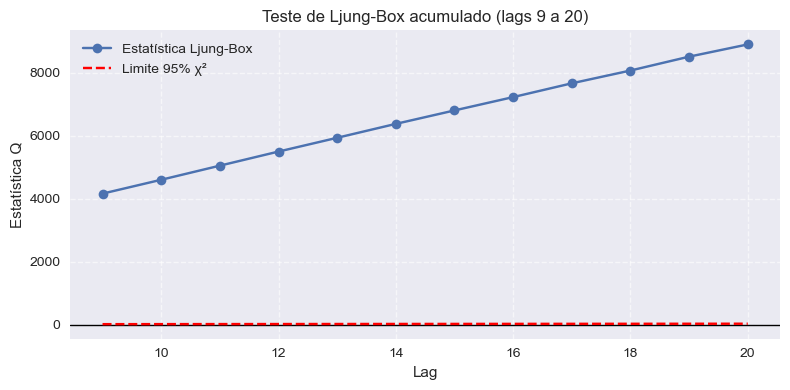

                            OLS Regression Results                            
Dep. Variable:            Rt_Rp_ew_cc   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     16.91
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           5.93e-08
Time:                        23:32:23   Log-Likelihood:                 3371.3
No. Observations:                1035   AIC:                            -6737.
Df Residuals:                    1032   BIC:                            -6722.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0122      0.000    -41.966      0.0

In [43]:
# --- TESTE DE LJUNG-BOX PARA LAGS 9 A 20 ---
lags = range(9, 21)  # de 9 até 20

# Calcular Ljung-Box para cada lag
ljung = acorr_ljungbox(fit.resid, lags=list(lags), return_df=True)

print("=== Teste de Ljung-Box (lags 9 a 20) ===")
print(ljung)

# --- PLOT ---
plt.figure(figsize=(8, 4))
plt.plot(ljung.index, ljung['lb_stat'], marker='o', label='Estatística Ljung-Box')
plt.axhline(y=0, color='black', linewidth=1)
plt.title('Teste de Ljung-Box acumulado (lags 9 a 20)')
plt.xlabel('Lag')
plt.ylabel('Estatística Q')
plt.grid(True, linestyle='--', alpha=0.6)

# Linha de referência do qui-quadrado (p=0.05)
from scipy.stats import chi2
df = ljung.index  # graus de liberdade = número de lags
plt.plot(ljung.index, chi2.ppf(0.95, df), 'r--', label='Limite 95% χ²')
plt.legend()
plt.tight_layout()
plt.show()

# Ajustar modelo
fit = sm.OLS(y, X_const).fit()
print(fit.summary())

#LJUNG-BOX
ljung = acorr_ljungbox(fit.resid, lags=[10], return_df=True)
print(ljung)

## **Ajuste - Newey-WEST(HAC,6 lags)**

=== COMPARATIVO ENTRE OLS E NEWEY-WEST (HAC, 6 lags) ===
        Coeficiente (β)  Erro Padrão OLS  Erro Padrão HAC(6)  p-valor OLS  \
const          -0.01224          0.00029             0.00065      0.00000   
Mom            -0.00051          0.00019             0.00028      0.00711   
ST_Rev          0.00077          0.00019             0.00029      0.00005   

        p-valor HAC(6)  Δ Erro (%)  
const          0.00000   121.77539  
Mom            0.06813    47.86667  
ST_Rev         0.00722    51.31450  


<Figure size 1000x600 with 0 Axes>

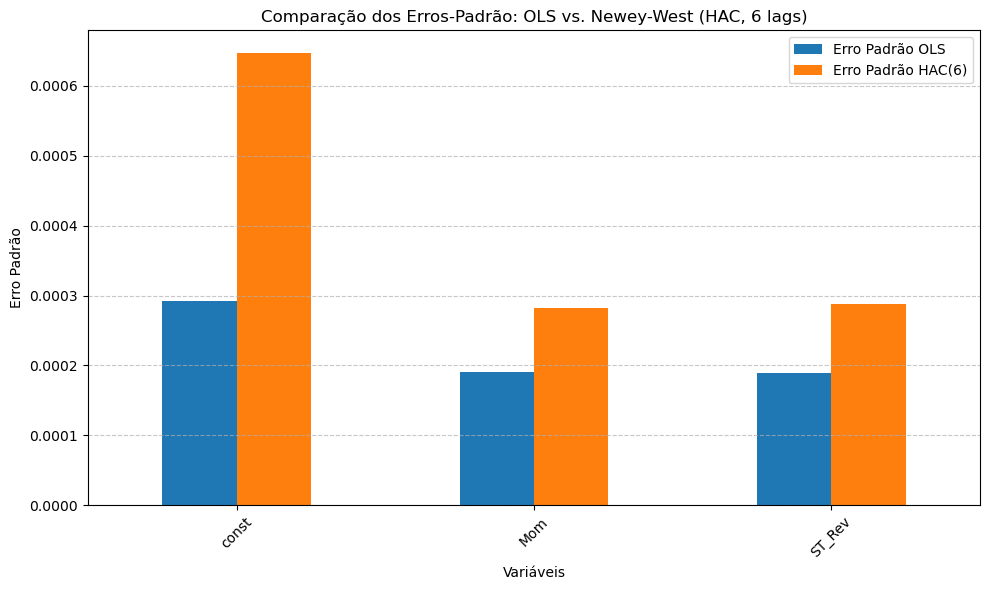

In [6]:
X_const = sm.add_constant(X)
modelo_ols = sm.OLS(y_clean, X_const).fit()
modelo_hac = sm.OLS(y_clean, X_const).fit(cov_type='HAC', cov_kwds={'maxlags': 6})

# Criar DataFrame comparativo
comparacao = pd.DataFrame({
    "Coeficiente (β)": modelo_ols.params,
    "Erro Padrão OLS": modelo_ols.bse,
    "Erro Padrão HAC(6)": modelo_hac.bse,
    "p-valor OLS": modelo_ols.pvalues,
    "p-valor HAC(6)": modelo_hac.pvalues
})

# Calcular diferença percentual dos erros-padrão
comparacao["Δ Erro (%)"] = 100 * (modelo_hac.bse - modelo_ols.bse) / modelo_ols.bse

# Exibir tabela
print("=== COMPARATIVO ENTRE OLS E NEWEY-WEST (HAC, 6 lags) ===")
print(comparacao.round(5))

# === Plotar comparação dos erros-padrão ===
plt.figure(figsize=(10, 6))
comparacao[["Erro Padrão OLS", "Erro Padrão HAC(6)"]].plot(kind='bar', figsize=(10,6))
plt.title("Comparação dos Erros-Padrão: OLS vs. Newey-West (HAC, 6 lags)")
plt.ylabel("Erro Padrão")
plt.xlabel("Variáveis")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### OBS: Aumento dos erros-padrãos indica que o modelo OLS subestimava a incerteza

In [9]:
# === 1. Definir X e Y ===
y = dados_validos["Rt_Rp_ew_cc"]
X = dados_validos[["Mom", "ST_Rev"]]
X_const = sm.add_constant(X)

# === 2. Ajustar o modelo com correção Newey-West (HAC, 6 lags) ===
modelo_hac = sm.OLS(y, X_const).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(modelo_hac.summary())

                            OLS Regression Results                            
Dep. Variable:            Rt_Rp_ew_cc   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     6.733
Date:                Thu, 16 Oct 2025   Prob (F-statistic):            0.00124
Time:                        01:33:13   Log-Likelihood:                 3371.3
No. Observations:                1035   AIC:                            -6737.
Df Residuals:                    1032   BIC:                            -6722.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0122      0.001    -18.923      0.0

## **8 - Importância Relativa dos Regressors**

  feature  importance
0  ST_Rev    0.035151
1     Mom    0.015538


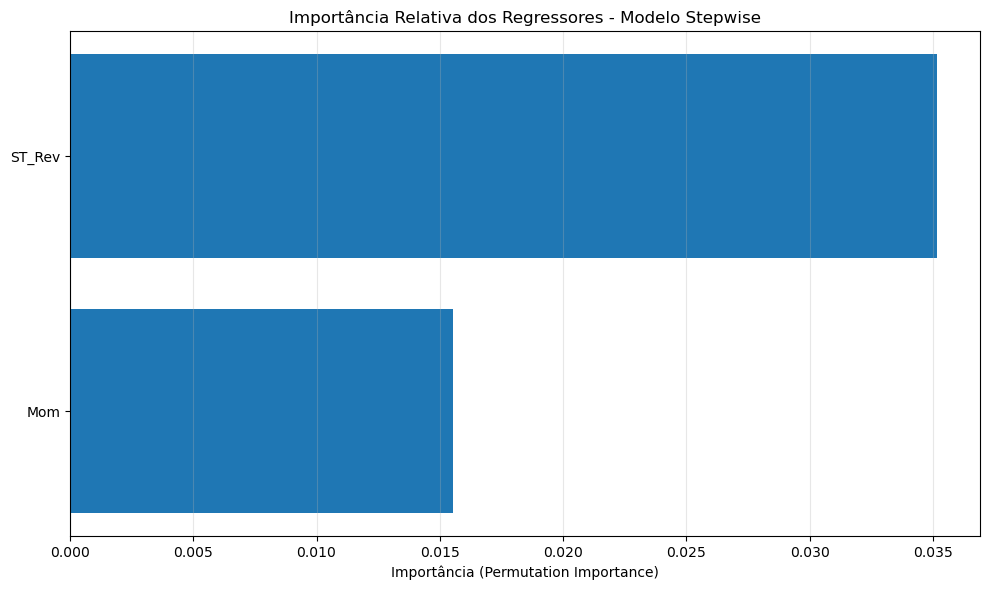


--- Estatísticas das Importâncias ---
Importância total: 0.050689
Importância média: 0.025344
Importância máxima: 0.035151
Importância mínima: 0.015538

--- Importância Relativa em Porcentagem ---
ST_Rev: 69.35%
Mom: 30.65%


In [58]:
# Importância Relativa dos Regressores - Modelo Stepwise

lin_reg = LinearRegression().fit(X_step, y_clean)
perm = permutation_importance(lin_reg, X_step, y_clean, n_repeats=100, random_state=42)

importances = pd.DataFrame({
    "feature": X_step.columns,
    "importance": perm.importances_mean
}).sort_values(by="importance", ascending=False)

print(importances)

# Gráfico de importância
plt.figure(figsize=(10, 6))
plt.barh(importances['feature'], importances['importance'])
plt.xlabel('Importância (Permutation Importance)')
plt.title('Importância Relativa dos Regressores - Modelo Stepwise')
plt.gca().invert_yaxis()  # Para mostrar o mais importante no topo
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Estatísticas adicionais
print(f"\n--- Estatísticas das Importâncias ---")
print(f"Importância total: {importances['importance'].sum():.6f}")
print(f"Importância média: {importances['importance'].mean():.6f}")
print(f"Importância máxima: {importances['importance'].max():.6f}")
print(f"Importância mínima: {importances['importance'].min():.6f}")

# Importância relativa em porcentagem
importances['importance_pct'] = (importances['importance'] / importances['importance'].sum()) * 100
print(f"\n--- Importância Relativa em Porcentagem ---")
for _, row in importances.iterrows():
    print(f"{row['feature']}: {row['importance_pct']:.2f}%")

## **9 - Resultados**

In [13]:
fit = sm.OLS(y, X_step).fit()
print(fit.summary())

                                 OLS Regression Results                                
Dep. Variable:            Rt_Rp_ew_cc   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              6.117
Date:                Wed, 08 Oct 2025   Prob (F-statistic):                     0.00229
Time:                        10:06:25   Log-Likelihood:                          2856.1
No. Observations:                1035   AIC:                                     -5708.
Df Residuals:                    1033   BIC:                                     -5698.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# **10 - Conclusão**

#  **Análise Exploratória**

| Análise | Resultado | Interpretação |
|---------|-----------|---------------|
| Série Temporal do Excesso de Retorno | Oscilações em torno de zero | Variação significativa dos retornos ao longo do tempo, com períodos de maior volatilidade no final da amostra |
| Correlação entre Variáveis | Baixas correlações entre fatores | Ausência de multicolinearidade preocupante entre as variáveis explicativas |

##  **Modelagem e Regressão**

| Modelo | Resultados | Significância |
|--------|------------|---------------|
| Regressão Linear Múltipla (OLS) | \( R^2 = 0.035 \), \( R^2 \) ajustado = 0.027 | Baixo poder explicativo do modelo |
| Significância dos Coeficientes | Apenas ST_Rev significativo (\( p < 0.05 \)) | Fatores tradicionais pouco explicativos para o excesso de retorno |

##  **Transformações e Seleção de Modelos**

### **Box-Cox**
- λ ótimo: 1.1896 → transformação de potência leve
- Resultado:\( R^2 \) aumentou para 0.0378
- Problema: Resíduos continuam não normais (\( p < 0.001 \) no teste Shapiro-Wilk)

### Seleção de Variáveis
| Método | Variáveis Selecionadas |
|--------|---------------------|
| **Backward** | MktRF, RMW, ST_Rev, LT_Rev |
| **Forward** | MktRF, RMW, CMA, ST_Rev |
| **Stepwise** | **ST_Rev, Mom** |

**Modelo mais parcimonioso:** **Stepwise (ST_Rev + Mom)**

##  **Diagnósticos do Modelo**

### **Multicolinearidade (VIF)**
- Todos os VIF < 2
- Número de condição = 1.85
- **Conclusão:** Sem sinais de multicolinearidade

### **Diagnóstico de Resíduos**
- Distribuição próxima à normal, mas com assimetria leve
- 118 observações com alto Cook's Distance e DFITS
- **Conclusão:** Presença de pontos influentes

### **Alavancagem e Outliers**
- Poucas observações ultrapassam limites de ±2 nos resíduos studentizados
- Limiar de alavancagem dentro do esperado
- **Conclusão:** Não há padrão sistemático de outliers

##  **Análise Temporal e Autocorrelação**

### **Autocorrelação (ACF/PACF)**
-  Forte autocorrelação dos resíduos
- ACF decai lentamente
- PACF com lags iniciais significativos
- **Conclusão:** Dependência temporal não capturada pelo modelo linear

### **Teste de Ljung-Box (lags 9–20)**
- Todos os p-values = 0
- **Conclusão:** Rejeita a hipótese de ausência de autocorrelação

  ### **Newey-WEST(HAC,6 lags))**
- Erro padrão aumenta na const, Mom e ST_Rev
- Modelo OLS subestimava a incerteza
- **Conclusão:** Modelo com erros-padrãos robustos, a inferência é mais confiável

##  **Importância dos Regressores (Modelo Stepwise)**

| Fator | Importância |
|-------|-------------|
| **ST_Rev** | 69.35% |
| **Mom** | 30.65% |

**ST_Rev é o fator mais relevante** na explicação do excesso de retorno

---

## **Conclusão Geral**

### **Principais Achados:**
1. **Baixo poder explicativo** - Modelo linear explica apenas ≈3.5% da variação
2. **ST_Rev e Mom** - Fatores mais relevantes no modelo parcimonioso
3. **Problemas de especificação** - Autocorrelação e não-normalidade nos resíduos
4. **Necessidade de modelos avançados** - Estrutura temporal não capturada

**Conclusão Final:** O processo possui dinâmica temporal que exige modelagem mais avançada para melhor captura das variações do excesso de retorno.xige modelagem mais avançada para melhor captura das variações do excesso de retorno.